In [40]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from PIL import Image
from nltk.translate import bleu_score

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

***

In [3]:
from src.utils.config import IMAGES_DIR
from src.utils.sets import (
    init_image_descriptions_map,
    load_set_images,
    init_image_descriptions_map_set,
    data_generator
)

from src.utils.image import load_image, load_image_embedding_map
from src.utils.sequence import clean, init_idx_word_map, init_word_idx_map

from src.nn import NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [4]:
image2descriptions = init_image_descriptions_map()

image2descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [5]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [6]:
for img_name, descriptions in image2descriptions.items():
    image2descriptions[img_name] = [clean(descr) for descr in descriptions]

In [7]:
image2descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [8]:
vocabulary = set()

for key in image2descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image2descriptions[key]]

In [9]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [10]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [11]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [12]:
word2idx = init_word_idx_map(vocabulary)
idx2word = init_idx_word_map(vocabulary)

In [13]:
word2idx['dog']

2224

In [14]:
idx2word[2224]

'dog'

***

## Max Description Length

In [15]:
descriptions = []

for key, val in image2descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [16]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [17]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [18]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps Sets

In [19]:
train_image2descriptions = init_image_descriptions_map_set(train_images, image2descriptions)
dev_image2descriptions = init_image_descriptions_map_set(dev_images, image2descriptions)
test_image2descriptions = init_image_descriptions_map_set(test_images, image2descriptions)

print('Train size: {}'.format(len(train_image2descriptions)))
print('Dev size: {}'.format(len(dev_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [20]:
train_image2descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Merge Train and Dev, hold-out set: Test

In [21]:
train_image2descriptions = {**train_image2descriptions, **dev_image2descriptions}

In [22]:
print('Train size: {}'.format(len(train_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 7000
Test size: 1000


***

## Creating Image-Embedding Maps

In [44]:
train_image2embedding = load_image_embedding_map('train', train_image2descriptions)
test_image2embedding = load_image_embedding_map('test', test_image2descriptions)

"train" Image-Embedding Map loaded.
Creating "test" Image-Embedding Map...
Done.


***

In [24]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [256, 256]

***

# Model

![NIC_model](../../img/NIC.png)

In [25]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
print(neural_image_captioning.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay (None, 2048)         0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
top_image_encoder (Model)       (None, 1, 300)       2405676     image_embedding_input[0][0]      
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     5978899     sequence_input[0][0]             
                                                                 top_image_encoder[1][0]          
Total para

***

## Run

### Callbacks

In [46]:
filepath = '../weights/nic-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss')


callbacks = [checkpoint, reduce_lr]

### Load / Compile

In [47]:
neural_image_captioning.model.load_weights('../weights/nic-weights.hdf5')

neural_image_captioning.model.compile(Adam(1e-5), loss='categorical_crossentropy')

### Prepare

In [ ]:
num_epochs = 1000
batch_size = 128
steps = (len(train_image2descriptions) * 5) // batch_size
val_batch_size = batch_size//4
val_steps = (len(test_image2descriptions) * 5) // val_batch_size


train_data_generator = data_generator(
    train_image2descriptions,
    train_image2embedding,
    word2idx,
    batch_size,
    max_description_length,
    len(vocabulary),
)

val_data_generator = data_generator(
    test_image2descriptions,
    test_image2embedding,
    word2idx,
    val_batch_size,
    max_description_length,
    len(vocabulary),
)

### Train

In [ ]:
neural_image_captioning.model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=steps,
    epochs=num_epochs,
    verbose=True,
    callbacks=callbacks,
    validation_data=val_data_generator,
    validation_steps=val_steps,
)

Epoch 1/1000
273/273 [==============================] - 129s 471ms/step - loss: 1.2694 - val_loss: 3.4522

Epoch 00001: saving model to ../weights/nic-weights.hdf5


/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_decoder_1 was passed non-serializable keyword arguments: {'mask': [<tf.Tensor 'sequence_decoder/glove_embeddings/NotEqual:0' shape=(?, 37) dtype=bool>, None, None], 'initial_state': [<tf.Tensor 'lstm_decoder_1/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_decoder_1/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/1000
141/273 [==============>...............] - ETA: 48s - loss: 1.2709

***

## Test

In [32]:
inference = NICInference(neural_image_captioning, word2idx)

In [33]:
def show_img(path_to_img):
    img = Image.open(path_to_img)
    img.load()
    plt.imshow(np.asarray(img, dtype='int32'));

def evaluate(img_id, beam_width=3):
    print('Image ID: {}'.format(img_id))
    print('='*50)
    print()
    img = load_image(img_id)
    
    greedy_hypothesis = inference.greedy_search(img)
    beam_hypothesis = inference.beam_search(img, beam_width=beam_width)
    references = image2descriptions[img_id]

    print('Greedy Search: {}'.format(greedy_hypothesis))
    print('Beam Search: {}'.format(beam_hypothesis))
    print()
    
    print('BLEU score Greedy Search: {}'.format(bleu_score.sentence_bleu(references, greedy_hypothesis)))
    print('BLEU score Beam Search: {}'.format(bleu_score.sentence_bleu(references, beam_hypothesis)))
    print()
    
    print('Greedy Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, greedy_hypothesis)))
    print('Beam Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, beam_hypothesis)))
    
    show_img(IMAGES_DIR+img_id+'.jpg')

Image ID: 1287073593_f3d2a62455

Greedy Search: a man in a blue jacket rides a dog sled over a snow covered plain
Beam Search: a man in a dog sled behind the of a team of snow

BLEU score Greedy Search: 0.5803381579825738
BLEU score Beam Search: 0.6766600410994146

Greedy Search Hypothesis Log Probabilty: -132.176025390625
Beam Search Hypothesis Log Probabilty: -106.53521728515625


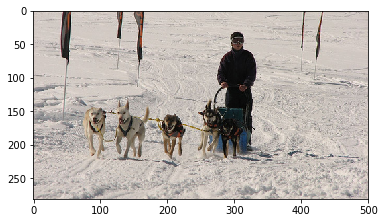

In [34]:

evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=10
)

Image ID: 315880837_90db309bab

Greedy Search: three dogs are playing in the snow
Beam Search: three dogs play of dogs in the snow

BLEU score Greedy Search: 0.8382234324229999
BLEU score Beam Search: 0.6881318254460197

Greedy Search Hypothesis Log Probabilty: -60.61603546142578
Beam Search Hypothesis Log Probabilty: -81.3670883178711


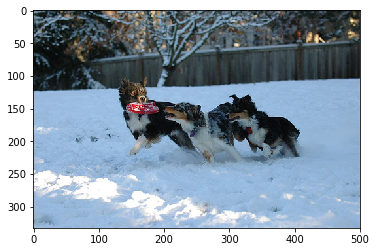

In [35]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=10
)

Image ID: 3197981073_3156963446

Greedy Search: a woman sings into a microphone by a man playing a guitar
Beam Search: a woman sings into a microphone

BLEU score Greedy Search: 0.8604859657187126
BLEU score Beam Search: 0.59682637785056

Greedy Search Hypothesis Log Probabilty: -110.67481994628906
Beam Search Hypothesis Log Probabilty: -56.01026153564453


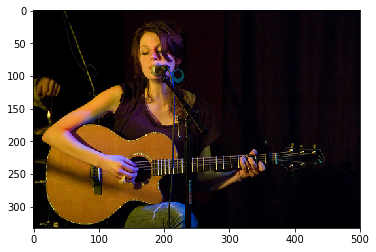

In [36]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=50
)

Image ID: 247637795_fdf26a03cf

Greedy Search: a man wearing a red shirt is standing next to a woman in black
Beam Search: a man stands men walk

BLEU score Greedy Search: 0.7475922842896188
BLEU score Beam Search: 0.3647351615496205

Greedy Search Hypothesis Log Probabilty: -125.94319152832031
Beam Search Hypothesis Log Probabilty: -44.166900634765625


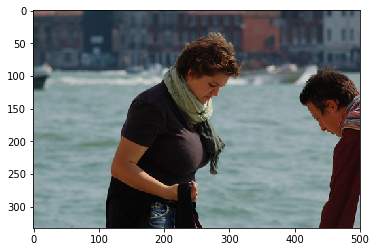

In [37]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=50
)

Image ID: 3503689049_63212220be

Greedy Search: a man wearing sunglasses and a blue shirt with a black bandanna smile
Beam Search: a man wearing sunglasses

BLEU score Greedy Search: 0.703899988329027
BLEU score Beam Search: 0.4256951149389544

Greedy Search Hypothesis Log Probabilty: -105.79769897460938
Beam Search Hypothesis Log Probabilty: -27.151805877685547


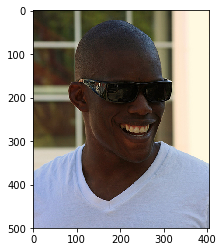

In [38]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=100
)

Image ID: 2900274587_f2cbca4c58

Greedy Search: a person is sitting on a boat in the water
Beam Search: people three people are fishing

BLEU score Greedy Search: 0.6204572744356099
BLEU score Beam Search: 4.406636300688642e-78



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Greedy Search Hypothesis Log Probabilty: -92.44708251953125
Beam Search Hypothesis Log Probabilty: -36.725120544433594


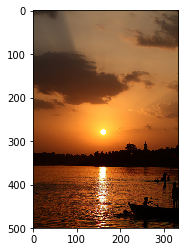

In [39]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=100
)